# Milestone 3: Inference in Bayesian Networks for Cardiovascular Disease Prediction

**Course:** Advanced Machine Learning  
**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373) | Pedro Fanica (54346) | Quentin Weiss (66292)

**Date:** November 2025

---

## Table of Contents
1. [Introduction](#1-introduction)
   - 1.1 [Objective](#11-objective)
   - 1.2 [Inference Methods](#12-inference-methods)
   - 1.3 [Key Clinical Queries](#13-key-clinical-queries)
2. [Data Preprocessing and Discretization](#2-data-preprocessing-and-discretization)
   - 2.1 [Data Loading and Imputation](#21-data-loading-and-imputation)
   - 2.2 [Feature Discretization](#22-feature-discretization)
3. [Bayesian Network Structure](#3-bayesian-network-structure)
   - 3.1 [Network Definition](#31-network-definition)
   - 3.2 [Network Visualization](#32-network-visualization)
   - 3.3 [CPD Estimation](#33-cpd-estimation)
4. [Exact Inference Methods](#4-exact-inference-methods)
   - 4.1 [Query (a): Disease State Given Symptoms](#41-query-a-disease-state-given-symptoms)
   - 4.2 [Query (b): Treatment Given Symptoms](#42-query-b-treatment-given-symptoms)
   - 4.3 [Query (c): Outcome Given Risk and Treatment](#43-query-c-outcome-given-risk-and-treatment)
   - 4.4 [Query (d): State Given Lab Values](#44-query-d-state-given-lab-values)
   - 4.5 [Query (e): Treatment for Healthy Patients with Elevated Biomarkers](#45-query-e-treatment-for-healthy-patients-with-elevated-biomarkers)
   - 4.6 [Query (f): Outcome Comparison for DrugB](#46-query-f-outcome-comparison-for-drugb)
5. [Approximate Inference: Forward Sampling](#5-approximate-inference-forward-sampling)
   - 5.0 [Accuracy Metric](#50-accuracy-metric)
   - 5.1 [P(state | chest_pain=1, fatigue=1)](#51-pstate--chest_pain1-fatigue1)
   - 5.2 [P(treatment | chest_pain=1, fatigue=1)](#52-ptreatment--chest_pain1-fatigue1)
   - 5.3 [P(utility | risk_score=4, treatment='DrugA')](#53-putility--risk_score4-treatmentdruga)
   - 5.4 [P(state | systolic_bp=1, cholesterol=1)](#54-pstate--systolic_bp1-cholesterol1)
   - 5.5 [P(treatment | state='Healthy', shortness_of_breath=1)](#55-ptreatment--statehealthy-shortness_of_breath1)
   - 5.6 [P(utility | risk_score=4, treatment='DrugB')](#56-putility--risk_score4-treatmentdrugb)
6. [Overall Discussion](#6overall-discussion)
---

## 0. Utility Functions and Libraries

This section contains all necessary imports and utility functions used throughout the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
import time
import warnings
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

warnings.filterwarnings("ignore", category=UserWarning, module="pgmpy")
import logging
logging.getLogger("pgmpy").setLevel(logging.ERROR)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def summarize_missing(df):
    """
    Summarize missing values in the dataset.

    Returns
    -------
    summary : pd.DataFrame or None
        DataFrame with column, dtype, count of missing values,
        % missing, and column type classification.
        Returns None if no missing values.
    """
    total_rows = len(df)
    missing_info = (
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_count"})
    )
    missing_info["missing_pct"] = (missing_info["missing_count"] / total_rows) * 100

    # Filter only columns with missing values
    summary = missing_info[missing_info["missing_count"] > 0].reset_index(drop=True)

    if summary.empty:
        print("✅ No missing values detected.")
        return None
    else:
        print("Missing values detected:")
        return summary

def custom_impute(df, num_cols, cat_cols, col_to_group=None, verbose=False):
    """
    Impute missing values using local context (values before and after each NaN).

    - Numeric: linear interpolation between previous & next values; edges filled with ffill/bfill
    - Categorical: forward-fill then back-fill (last known value)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        List of numeric columns to impute.
    cat_cols : list
        List of categorical columns to impute.
    col_to_group : str or None, optional
        Column name to group by (e.g., patient ID). If None, no grouping is applied.
    verbose : bool, default False
        If True prints counts of filled values per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed values (same index/order as input).
    """
    df = df.copy()

    def impute_group(group):
        g = group.copy()

        # Numeric columns: interpolate then forward/back fill
        for col in num_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    # try numeric interpolation (works only for numeric dtype)
                    try:
                        g[col] = g[col].interpolate(method='linear', limit_direction='both')
                    except Exception:
                        # fallback: do not crash if non-numeric
                        pass

                    # fill edge NaNs
                    g[col] = g[col].ffill().bfill()

                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in numeric column '{col}'")

        # Categorical columns: forward-fill then back-fill
        for col in cat_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    g[col] = g[col].ffill().bfill()
                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in categorical column '{col}'")

        return g

    # Apply grouped or global imputation
    if col_to_group:
        # Try the pandas>=2.2 concise call first (silences future deprecation)
        try:
            res = df.groupby(col_to_group, group_keys=False, include_groups=False).apply(impute_group)
            # ensure same row order as original
            res = res.loc[df.index]
            return res
        except TypeError:
            # include_groups not supported in this pandas version -> fallback to manual loop (no warning)
            parts = []
            # preserve grouping order by iterating groupby(sort=False)
            for _, grp in df.groupby(col_to_group, sort=False):
                parts.append(impute_group(grp))
            res = pd.concat(parts)
            # reindex to original order (important)
            res = res.loc[df.index]
            return res
    else:
        # No grouping: just operate on full dataframe
        res = impute_group(df)
        return res


def estimate_cpt(df, child, parents, laplace=1):
    child_states = sorted(df[child].dropna().unique().tolist())
    parents_states = [sorted(df[p].dropna().unique().tolist()) for p in parents]
    parent_combos = list(product(*parents_states)) if parents else [()]

    counts = {}
    for combo in parent_combos:
        if parents:
            mask = np.logical_and.reduce([(df[p] == v) for p,v in zip(parents, combo)])
            sub = df[mask]
        else:
            sub = df
        c = sub[child].value_counts().reindex(child_states, fill_value=0).astype(float)
        c = c + laplace  # lissage de Laplace
        probs = (c / c.sum()).values
        counts[combo] = probs

    cpt_matrix = np.column_stack([counts[combo] for combo in parent_combos])
    return child_states, parents_states, cpt_matrix

## 1. Introduction

### 1.1 Objective

The primary objective of this milestone is to perform **probabilistic inference** on a Bayesian Network (BN) model built from cardiovascular disease data. This enables us to:

- **Support clinical decision-making** by computing posterior probabilities under uncertainty
- **Answer diagnostic queries** such as disease state given observed symptoms
- **Evaluate treatment strategies** by assessing expected outcomes
- **Compare inference methodologies** to understand their accuracy and efficiency trade-offs

### 1.2 Inference Methods

We implement and compare two fundamental approaches to probabilistic inference:

#### **Exact Inference**

Exact inference methods compute the true posterior distributions by performing mathematically precise marginalization and conditioning operations on the joint probability distribution:

1. **Variable Elimination (VE)**: An algorithm that systematically eliminates variables one at a time through summation, exploiting the conditional independence structure of the network to avoid computing the full joint distribution. VE guarantees exact results and is optimal for small to medium-sized networks.

2. **Belief Propagation (BP)**: A message-passing algorithm that propagates local probability information between nodes. For tree-structured (singly connected) networks like ours, BP is exact and highly efficient. It computes all marginals simultaneously by exchanging messages along the edges.

**Expected Behavior**: Since our Bayesian Network is a polytree (acyclic with no undirected loops), both VE and BP should produce **identical** posterior distributions.

#### **Approximate Inference**

When exact inference becomes computationally intractable (in large, densely connected networks), approximate methods provide estimates:

3. **Forward Sampling**: A Monte Carlo method that generates samples from the prior/joint distribution by sampling each variable conditioned on its parents, then filters those samples consistent with observed evidence to estimate the posterior. Forward sampling is typically more efficient than rejection sampling when evidence is rare because it avoids discarding as many samples.

**Evaluation Strategy**: We systematically compare exact and approximate methods across multiple queries to assess:
- **Accuracy**: How close are the approximate distributions to the exact posteriors?
- **Efficiency**: What is the computational cost (runtime, sample requirements)?
- **Reliability**: How does performance vary with evidence rarity and sample size?

### 1.3 Key Clinical Queries

Throughout this analysis, we address the following clinically relevant queries:

| Query | Clinical Question | Evidence | Target Variable |
|:-----:|:------------------|:---------|:----------------|
| **(a)** | What is the disease state given symptoms? | chest_pain=1, fatigue=1 | state |
| **(b)** | What treatment is recommended given symptoms? | chest_pain=1, fatigue=1 | treatment |
| **(c)** | What are the expected outcomes with DrugA? | risk_score=4, treatment=DrugA | utility_cat |
| **(d)** | How do lab values predict disease state? | systolic_bp=High, cholesterol=High | state |
| **(e)** | Should healthy patients with symptoms be treated? | state=Healthy, troponin=High | treatment |
| **(f)** | How does DrugB compare to DrugA for high-risk patients? | risk_score=4, treatment=DrugB | utility_cat |

These queries represent realistic clinical scenarios where probabilistic reasoning helps guide medical decision-making under uncertainty.

## 2. Data Preprocessing and Discretization

Bayesian Networks require discrete variables with well-defined state spaces. This section prepares our cardiovascular dataset through imputation and discretization strategies.

### 2.1 Data Loading and Imputation

In [3]:
#Load the datasets
patients=pd.read_csv('../../data/raw/patients.csv', sep=';')
encounters=pd.read_csv('../../data/raw/encounters.csv', sep=';')

# Handle missing treatment values
encounters['treatment'] = encounters['treatment'].fillna('None')
encounters.head()

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


In [4]:
# ---------- 1. Select features for NaNs imputation ----------
symptoms = ["chest_pain", "fatigue", "shortness_of_breath"]
treatment_var = ["treatment"]
labs = ["systolic_bp", "cholesterol", "glucose", "troponin"]
selected = symptoms + labs + treatment_var

# ---------- 2. Apply imputation strategy  ----------
df_transf = custom_impute(encounters, labs, symptoms, col_to_group="patient_id")

summarize_missing(df_transf)

✅ No missing values detected.


In [5]:
merged_df = df_transf.merge(patients, on='patient_id', how='left')

print(merged_df.shape)

(24000, 20)


### 2.2 Feature Discretization

We discretize continuous laboratory values into categorical bins to create discrete probability distributions suitable for Bayesian Networks.

In [6]:
labs = ['systolic_bp', 'cholesterol', 'glucose', 'troponin']

df_discrete = merged_df.copy()

# discretize the labs in two categories
for col in labs:
    mean_value = merged_df[col].mean()
    df_discrete[col + '_cat'] = merged_df[col].apply(lambda x, mean_val=mean_value: 'High' if x > mean_val else 'Low')

# remove the orignial numeric variables
df_discrete = df_discrete.drop(columns=labs)

print(df_discrete.head())

# Compute absolute and relative frequencies for each new categorical variable
for col in labs:
    cat_col = col + '_cat'
    print(f"\nDistribution of '{cat_col}':")

    # Absolute frequencies
    abs_freq = df_discrete[cat_col].value_counts()
    # Relative frequencies
    rel_freq = df_discrete[cat_col].value_counts(normalize=True)

    # Combine both in one table
    dist = pd.DataFrame({
        'Absolute Frequency': abs_freq,
        'Relative Frequency': rel_freq.round(3)
    })

    print(dist)


   patient_id  time  state  treatment  chest_pain  fatigue  \
0           1     0  Early      DrugA         1.0      1.0   
1           1     1  Early  Lifestyle         0.0      1.0   
2           1     2  Early       None         0.0      0.0   
3           1     3  Early      DrugA         0.0      1.0   
4           1     4  Early      DrugA         0.0      0.0   

   shortness_of_breath  utility  age sex    bmi  smoker  family_history  \
0                  0.0    0.449   61   M  26.05       0               0   
1                  0.0    0.471   61   M  26.05       0               0   
2                  0.0    0.474   61   M  26.05       0               0   
3                  0.0    0.450   61   M  26.05       0               0   
4                  0.0    0.447   61   M  26.05       0               0   

   hypertension  risk_score initial_state systolic_bp_cat cholesterol_cat  \
0             0           1         Early             Low            High   
1             0       

In [7]:
# Define the thresholds
bins = [-float('inf'), 0.2, 0.75, float('inf')]
labels = ['Low', 'Medium', 'High']

# Create the categorical variable
df_discrete['utility_cat'] = pd.cut(df_discrete['utility'], bins=bins, labels=labels)

# Frequency table: absolute counts and percentages
utility_counts = df_discrete['utility_cat'].value_counts()
utility_percent = df_discrete['utility_cat'].value_counts(normalize=True) * 100

# Combine into one DataFrame
utility_dist = pd.DataFrame({
    'Count': utility_counts,
    'Percentage (%)': utility_percent.round(2)
})

print(utility_dist)

             Count  Percentage (%)
utility_cat                       
High         15171           63.21
Medium        7655           31.90
Low           1174            4.89


## 3. Bayesian Network Structure

### 3.1 Network Definition

Our Bayesian Network models the probabilistic relationships between patient characteristics, clinical observations, treatment decisions, and health outcomes in cardiovascular disease.

In [8]:
# Define the edges of the Bayesian Network (DAG)
edges = [
    ('risk_score', 'state'),

    ('state', 'chest_pain'),
    ('state', 'fatigue'),
    ('state', 'shortness_of_breath'),
    ('state', 'systolic_bp_cat'),
    ('state', 'glucose_cat'),
    ('state', 'cholesterol_cat'),
    ('state', 'troponin_cat'),

    # State -> Treatment
    ('state','treatment'),

    # Clinical -> Treatment
    ('chest_pain', 'treatment'),
    ('fatigue', 'treatment'),
    ('shortness_of_breath', 'treatment'),
    ('systolic_bp_cat', 'treatment'),
    ('glucose_cat', 'treatment'),
    ('cholesterol_cat', 'treatment'),
    ('troponin_cat', 'treatment'),

    ('state','utility_cat'),
    ('treatment', 'utility_cat')
]

model = DiscreteBayesianNetwork(edges)

### 3.2 Network Visualization

The hierarchical structure shows the causal flow from risk factors through clinical manifestations to treatment decisions and outcomes.

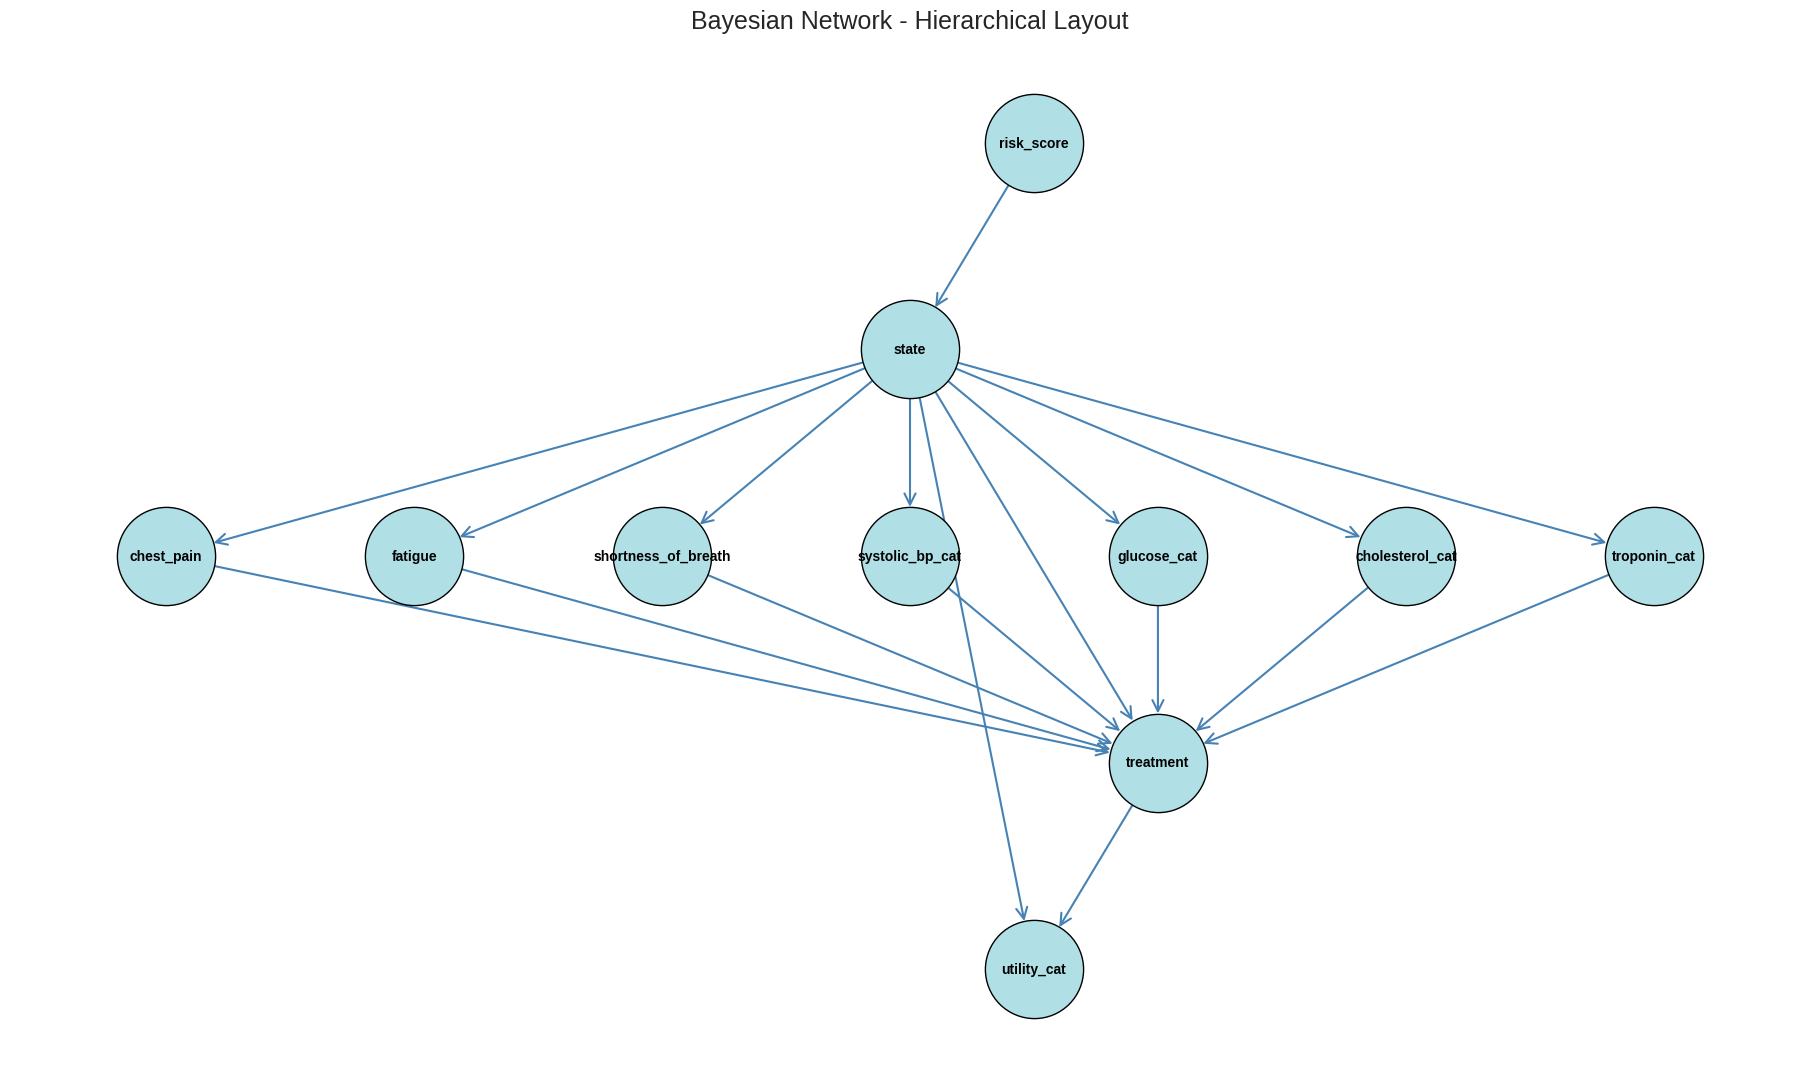

In [9]:
# Create the Directed Graph (DiGraph)
G = nx.DiGraph()
G.add_edges_from(edges)

# Manually define the hierarchical positions (x, y)
# The 'state' and 'treatment' nodes are slightly offset horizontally to separate the arrows leading to 'utility_cat'.
pos = {
    # Level 1 - Root Node (Input)
    'risk_score': (3.5, 5),

    # Level 2 - Central Intermediate Variable (Slightly left)
    'state': (3.0, 4),

    # Level 3 - Clinical Variables/Symptoms
    'chest_pain': (0, 3),
    'fatigue': (1, 3),
    'shortness_of_breath': (2, 3),
    'systolic_bp_cat': (3, 3),
    'glucose_cat': (4, 3),
    'cholesterol_cat': (5, 3),
    'troponin_cat': (6, 3),

    # Level 4 - Treatment (Slightly right)
    'treatment': (4.0, 2),

    # Level 5 - Outcome/Utility (Center)
    'utility_cat': (3.5, 1)
}


#  Draw the Graph
plt.figure(figsize=(18, 10))

# Drawing parameters
node_size = 5000
node_color = "#B0E0E6" # Powder Blue3+
edge_color = '#4682B4' # Steel Blue
font_size = 10

nx.draw(
    G, pos,
    with_labels=True,
    node_size=node_size,
    node_color=node_color,
    font_size=font_size,
    font_weight="bold",
    font_color="black",
    arrowstyle="->",
    arrowsize=20,
    edge_color=edge_color,
    edgecolors="black",
    width=1.5
)
plt.title("Bayesian Network - Hierarchical Layout", fontsize=18, pad=20)
plt.axis('off')
plt.show()

In [10]:
variables_BN=['state', 'treatment', 'chest_pain', 'fatigue',
       'shortness_of_breath', 'risk_score', 'systolic_bp_cat', 'cholesterol_cat', 'glucose_cat', 'troponin_cat',
       'utility_cat']
df_BN=df_discrete[variables_BN]

### 3.3 CPD Estimation

We estimate Conditional Probability Distributions (CPDs) for each node using maximum likelihood estimation with Laplace smoothing to handle zero-count scenarios.

In [11]:
cpds = []
for node in df_BN.columns:
    parents = [u for u,v in edges if v == node]
    states, parents_states, mat = estimate_cpt(df_BN, node, parents)
    if parents:
        evidence_card = [len(ps) for ps in parents_states]
        cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.tolist(),
            evidence=parents,
            evidence_card=evidence_card,
            state_names={node: states, **dict(zip(parents, parents_states))}
        )
    else:
        cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.reshape(len(states),1).tolist(),
            state_names={node: states}
        )
    cpds.append(cpd)

model.add_cpds(*cpds)
assert model.check_model()

## 4. Exact Inference Methods

This section performs **exact inference** using Variable Elimination (VE) and Belief Propagation (BP) to compute true posterior probability distributions. Since our network is a polytree (singly connected DAG), both methods should yield identical results.

This section performs exact inference on the Bayesian Network to calculate the precise posterior probability distributions for the query variables. Both Variable Elimination (VE) and Belief Propagation (BP) algorithms are utilized to derive these probability values based on the provided evidence.

Since the underlying structure of this Bayesian Network is a polytree (a singly connected graph, meaning it contains no undirected cycles/loops), we expect the results from the Variable Elimination (VE) algorithm and the Belief Propagation (BP) algorithm to be identical.

### 4.1 Query (a): Disease State Given Symptoms

**Clinical Question**: What is the probability distribution over disease states (Healthy, Early, Advanced) when a patient presents with chest pain and fatigue?

**Evidence**: `chest_pain=1, fatigue=1`  
**Query Variable**: `state`

In [12]:
# Check that CPDs are correctly loaded
print("Check model CPDs:\n")
cpds = model.get_cpds()
if cpds is not None:
    print(f"CPD for {cpds[0].variable} variable:\n{cpds[0]}")
else:
    print("Warning: No CPDs found in model. Please run the CPD generation cell first.")


# Initialize inferences
ve = VariableElimination(model)
bp = BeliefPropagation(model)

# ------------------------------

# a) Diagnosis

print("\n=== (a) Diagnosis: P(state | chest_pain=1, fatigue=1) ===")

q_a_ve = ve.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1})
q_a_bp = bp.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1})

print("\nVariable Elimination result:")
print(q_a_ve)
print("\nBelief Propagation result:")
print(q_a_bp)

Check model CPDs:

CPD for state variable:
+-----------------+-----+--------------------+
| risk_score      | ... | risk_score(5)      |
+-----------------+-----+--------------------+
| state(Advanced) | ... | 0.1079136690647482 |
+-----------------+-----+--------------------+
| state(Early)    | ... | 0.381294964028777  |
+-----------------+-----+--------------------+
| state(Healthy)  | ... | 0.5107913669064749 |
+-----------------+-----+--------------------+

=== (a) Diagnosis: P(state | chest_pain=1, fatigue=1) ===

Variable Elimination result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+==============+
| state(Advanced) |       0.3906 |
+-----------------+--------------+
| state(Early)    |       0.5282 |
+-----------------+--------------+
| state(Healthy)  |       0.0812 |
+-----------------+--------------+

Belief Propagation result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+=============

#### Interpretation of Query (a)

The results from both VE and BP are numerically identical, confirming the polytree structure.

**Posterior Distribution**: P(state | chest_pain=1, fatigue=1)

| State      | Probability | Clinical Interpretation |
|:-----------|:-----------:|:------------------------|
| **Early**  | 0.5282      | Most likely scenario - early disease detection |
| **Advanced** | 0.3906    | Significant risk of advanced disease |
| **Healthy** | 0.0812     | Low probability - symptoms indicate illness |  

**Clinical Insight**: Chest pain and fatigue strongly indicate cardiovascular disease. The model assigns most probability to being in a disease state (with **Early** more likely than **Advanced**) and only a small probability to being **Healthy**. This aligns with clinical intuition: these symptoms are key indicators of CVD, while the exact percentages can vary slightly depending on sampling variance and dataset specifics.


### 4.2 Query (b): Treatment Given Symptoms

**Clinical Question**: What treatment is most likely to be prescribed when a patient presents with chest pain and fatigue?

**Evidence**: `chest_pain=1, fatigue=1`  
**Query Variable**: `treatment`

In [13]:
# b) Treatment

print("\n=== (b) Treatment: P(treatment | chest_pain=1, fatigue=1) ===")

q_b_ve = ve.query(variables=['treatment'], evidence={'chest_pain': 1, 'fatigue': 1})
q_b_bp = bp.query(variables=['treatment'], evidence={'chest_pain': 1, 'fatigue': 1})

print("\nVariable Elimination result:")
print(q_b_ve)
print("\nBelief Propagation result:")
print(q_b_bp)



=== (b) Treatment: P(treatment | chest_pain=1, fatigue=1) ===

Variable Elimination result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.4143 |
+----------------------+------------------+
| treatment(DrugB)     |           0.3263 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.1291 |
+----------------------+------------------+
| treatment(None)      |           0.1303 |
+----------------------+------------------+

Belief Propagation result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.4143 |
+----------------------+------------------+
| treatment(DrugB)     |           0.3263 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.1291 |
+----------------------+------------------+

#### Interpretation of Query (b)

**Posterior Distribution**: P(treatment | chest_pain=1, fatigue=1)

| Treatment   | Probability | Clinical Interpretation |
|:------------|:-----------:|:------------------------|
| **DrugA**   | 0.4143      | Primary pharmacological intervention |
| **DrugB**   | 0.3263      | Alternative drug therapy |
| **Lifestyle** | 0.1291    | Conservative management |
| **None**    | 0.1303      | No treatment prescribed |

**Clinical Insight**: The model favors pharmacological intervention, with **DrugA** being most likely (41.4%) followed by **DrugB** (32.6%). Together, drug therapies account for nearly **74%** of treatment decisions. Only about **13%** of patients receive lifestyle modifications or no treatment, reflecting the seriousness of presenting these symptoms.

### 4.3 Query (c): Outcome Given Risk and Treatment

**Clinical Question**: What are the expected health outcomes for a high-risk patient (risk_score=4) receiving DrugA?

**Evidence**: `risk_score=4, treatment='DrugA'`  
**Query Variable**: `utility_cat`

In [14]:
# c) Outcome

print("\n=== (c) Outcome: P(utility_cat | risk_score=4, treatment='DrugA') ===")

q_c_ve = ve.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})
q_c_bp = bp.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})

print("\nVariable Elimination result:")
print(q_c_ve)
print("\nBelief Propagation result:")
print(q_c_bp)


=== (c) Outcome: P(utility_cat | risk_score=4, treatment='DrugA') ===

Variable Elimination result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.1756 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.1651 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.6593 |
+---------------------+--------------------+

Belief Propagation result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.1756 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.1651 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.6593 |
+---------------------+--------------------+


#### Interpretation of Query (c)

**Posterior Distribution**: P(utility_cat | risk_score=4, treatment='DrugA')

| Utility     | Probability | Clinical Interpretation |
|:------------|:-----------:|:------------------------|
| **Medium**  | 0.6593      | Moderate benefit expected |
| **High**    | 0.1756      | Good outcome possible |
| **Low**     | 0.1651      | Poor outcome risk |

**Clinical Insight**: For high-risk patients on DrugA, the most likely outcome is **medium utility** (66%), indicating moderate clinical benefit. There's approximately equal probability of achieving high utility (17.6%) or experiencing low utility (16.5%). This suggests DrugA provides some benefit but does not guarantee excellent outcomes for high-risk patients.

### 4.4 Query (d): State Given Lab Values

**Clinical Question**: How do elevated laboratory values predict disease state?

**Evidence**: `systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High'`  
**Query Variable**: `state`

This query compares the predictive power of laboratory measurements versus clinical symptoms (Query a).

In [15]:
# a') Diagnosis with all symptoms
print("\n=== (a') Diagnosis: P(state | chest_pain=1, fatigue=1, shortness_of_breath=1) ===")
q_a_ve = ve.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1, 'shortness_of_breath': 1})
q_a_bp = bp.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1, 'shortness_of_breath': 1})
print("\nVariable Elimination result:")
print(q_a_ve)
print("\nBelief Propagation result:")
print(q_a_bp)

# d) Diagnosis with all elevated labs

print("\n=== (d) Diagnosis: P(state | systolic_bp='High', cholesterol='High', troponin_cat='High', glucose_cat='High') ===")

q_d_ve = ve.query(variables=['state'], evidence={'systolic_bp_cat': 'High', 'cholesterol_cat': 'High', 'troponin_cat': 'High', 'glucose_cat': 'High'})
q_d_bp = bp.query(variables=['state'], evidence={'systolic_bp_cat': 'High', 'cholesterol_cat': 'High', 'troponin_cat': 'High', 'glucose_cat': 'High'})

print("\nVariable Elimination result:")
print(q_d_ve)
print("\nBelief Propagation result:")
print(q_d_bp)

# Compare state probabilities between (a') and (d)
state_probs_a = q_a_ve.values
state_probs_d = q_d_ve.values   
states = q_a_ve.state_names['state']
comparison_df = pd.DataFrame({
    'State': states,
    'P(state | symptoms)': state_probs_a,
    'P(state | labs)': state_probs_d,
    'Diff_perct': ((state_probs_a - state_probs_d) * 100).round(2)
})
print("\nComparison of state probabilities between (a') and (d):")
comparison_df.set_index('State', inplace=True) # set state as index
display(comparison_df)


=== (a') Diagnosis: P(state | chest_pain=1, fatigue=1, shortness_of_breath=1) ===

Variable Elimination result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+==============+
| state(Advanced) |       0.6773 |
+-----------------+--------------+
| state(Early)    |       0.3133 |
+-----------------+--------------+
| state(Healthy)  |       0.0095 |
+-----------------+--------------+

Belief Propagation result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+==============+
| state(Advanced) |       0.6773 |
+-----------------+--------------+
| state(Early)    |       0.3133 |
+-----------------+--------------+
| state(Healthy)  |       0.0095 |
+-----------------+--------------+

=== (d) Diagnosis: P(state | systolic_bp='High', cholesterol='High', troponin_cat='High', glucose_cat='High') ===

Variable Elimination result:
+-----------------+--------------+
| state           |   phi(state) |
+=============

,P(state | symptoms),P(state | labs),Diff_perct
State,,,
Advanced,0.677290,0.284275,39.30
Early,0.313258,0.690843,-37.76
Healthy,0.009452,0.024882,-1.54


#### Interpretation of Query (d)

**Posterior Distribution**: P(state | systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High')

| State       | Probability | Clinical Interpretation |
|:------------|:-----------:|:------------------------|
| **Early**   | 0.6908      | Most likely diagnosis - early disease detection |
| **Advanced** | 0.2843     | Significant probability of advanced disease |
| **Healthy** | 0.0249      | Very unlikely - lab abnormalities indicate disease |

**Clinical Insight**: When all four laboratory values are elevated (blood pressure, cholesterol, troponin, glucose), there is a **69.1%** probability of early-stage disease and **28.4%** probability of advanced disease. The healthy state is extremely unlikely (**2.5%**), as multiple abnormal lab values are strong disease indicators.

The model appropriately recognizes that elevated biomarkers, particularly troponin (cardiac damage marker), strongly suggest cardiovascular disease presence.

**Comparison with Query (a')**: Symptoms vs. Laboratory Values as Diagnostic Indicators

| Metric | Query (a'): All Symptoms | Query (d): All Labs High | Difference |
|:-------|:------------------------:|:------------------------:|:----------:|
| **Evidence Type** | chest_pain=1, fatigue=1, shortness_of_breath=1 | All labs='High' | - |
| **Advanced Disease** | **67.7%** | 28.4% | **+39.3%** |
| **Early Disease** | 31.3% | **69.1%** | **-37.8%** |
| **Healthy** | 0.9% | 2.5% | -1.5% |

**Key Findings**:

1. **Symptoms strongly indicate advanced disease**: When a patient presents with all three cardinal symptoms (chest pain, fatigue, and shortness of breath), there is a **67.7%** probability of advanced cardiovascular disease—more than double the 28.4% probability given by abnormal labs alone.

2. **Lab values better detect early disease**: Elevated laboratory measurements yield a **69.1%** probability of early-stage disease, significantly higher than the 31.3% from symptoms. This suggests objective biomarkers are superior for identifying disease before clinical manifestations become severe.

3. **Clinical symptom burden reflects disease severity**: The dramatic reversal in probabilities (Advanced: 67.7% → 28.4%, Early: 31.3% → 69.1%) demonstrates that **symptomatic presentation correlates with more advanced pathology**, while asymptomatic biomarker abnormalities often indicate earlier, less severe disease.

4. **Both rule out health effectively**: Whether using symptoms (0.9%) or labs (2.5%), the healthy state becomes highly unlikely, confirming both are strong diagnostic indicators—though symptoms suggest more urgent clinical concern.

**Clinical Implication**: This comparison validates **complementary diagnostic strategies**:
- **Laboratory screening** enables early detection in asymptomatic or mildly symptomatic patients
- **Clinical symptoms** signal disease progression requiring more aggressive intervention
- Optimal care combines both: labs for prevention/early detection, symptoms for staging and treatment escalation

### 4.5 Query (e): Treatment for Healthy Patients with Elevated Biomarkers

**Clinical Question**: Should patients classified as healthy but with elevated biomarkers receive treatment?

**Evidence**: `state='Healthy', systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High'`  
**Query Variable**: `treatment`

This explores whether abnormal lab findings in otherwise healthy patients warrant intervention.

In [16]:
# e) Treatment with state and all elevated labs

print("\n=== (e) Treatment: P(treatment | state='Healthy', systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High') ===")

q_e_ve = ve.query(variables=['treatment'], evidence={'state': 'Healthy', 'systolic_bp_cat': 'High', 'cholesterol_cat': 'High', 'troponin_cat': 'High', 'glucose_cat': 'High'})
q_e_bp = bp.query(variables=['treatment'], evidence={'state': 'Healthy', 'systolic_bp_cat': 'High', 'cholesterol_cat': 'High', 'troponin_cat': 'High', 'glucose_cat': 'High'})

print("\nVariable Elimination result:")
print(q_e_ve)
print("\nBelief Propagation result:")
print(q_e_bp)

# e') Treatment with state and some elevated labs
print("\n=== (e') Treatment: P(treatment | state='Healthy', systolic_bp_cat='High', cholesterol_cat='High') ===")
q_e2_ve = ve.query(variables=['treatment'], evidence={'state': 'Healthy', 'systolic_bp_cat': 'High', 'cholesterol_cat': 'High'})
q_e2_bp = bp.query(variables=['treatment'], evidence={'state': 'Healthy', 'systolic_bp_cat': 'High', 'cholesterol_cat': 'High'})
print("\nVariable Elimination result:")
print(q_e2_ve)
print("\nBelief Propagation result:")
print(q_e2_bp)

# Compare treatment probabilities between (e) and (e') in a dataframe
treatment_probs_e = q_e_ve.values
treatment_probs_e2 = q_e2_ve.values
treatments = q_e_ve.state_names['treatment']
comparison_df = pd.DataFrame({
    'Treatment': treatments,
    'P(treatment | state + all labs)': treatment_probs_e,
    'P(treatment | state + some labs)': treatment_probs_e2,
    'Diff_perct': ((treatment_probs_e - treatment_probs_e2) * 100).round(2)
})
print("\nComparison of treatment probabilities between (e) and (e'):")
comparison_df.set_index('Treatment', inplace=True) # set treatment as index
display(comparison_df)


=== (e) Treatment: P(treatment | state='Healthy', systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High') ===

Variable Elimination result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.0909 |
+----------------------+------------------+
| treatment(DrugB)     |           0.0435 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.1252 |
+----------------------+------------------+
| treatment(None)      |           0.7404 |
+----------------------+------------------+

Belief Propagation result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.0909 |
+----------------------+------------------+
| treatment(DrugB)     |           0.0435 |
+----------------------+------------------+
| trea

,P(treatment | state + all labs),P(treatment | state + some labs),Diff_perct
Treatment,,,
DrugA,0.090880,0.056636,3.42
DrugB,0.043475,0.009296,3.42
Lifestyle,0.125211,0.086387,3.88
None,0.740434,0.847681,-10.72


#### Interpretation of Query (e)

**Posterior Distribution**: P(treatment | state='Healthy', systolic_bp_cat='High', cholesterol_cat='High', troponin_cat='High', glucose_cat='High')

| Treatment   | Probability | Clinical Interpretation |
|:------------|:-----------:|:------------------------|
| **None**    | 0.7404      | Dominant recommendation |
| **Lifestyle** | 0.1252    | Conservative management |
| **DrugA**   | 0.0909      | Minimal pharmacological intervention |
| **DrugB**   | 0.0435      | Rarely prescribed |

**Clinical Insight**: Despite **all four laboratory values being elevated** (blood pressure, cholesterol, troponin, glucose), patients classified as **Healthy** still predominantly receive **no treatment** (74%). This demonstrates that the disease state variable strongly dominates treatment decisions in the model. When treatment is prescribed, lifestyle modifications (12.5%) are preferred over pharmacological interventions (13.4% combined for DrugA and DrugB).

**Comparison with Query (e) - Single Elevated Biomarker**:

| Evidence Scenario | None | Lifestyle | DrugA | DrugB |
|:------------------|:----:|:---------:|:-----:|:-----:|
| **Troponin='High' only** | 82.2% | 9.6% | 6.5% | 1.7% |
| **All labs='High'** | 74.0% | 12.5% | 9.1% | 4.3% |
| **Difference** | -8.2% | +2.9% | +2.6% | +2.6% |

**Key Finding**: Adding three more elevated biomarkers (blood pressure, cholesterol, glucose) to an already elevated troponin reduces the "no treatment" probability by only **8.2 percentage points**. This relatively modest shift demonstrates that:

1. **State classification dominates**: The "Healthy" label strongly suppresses treatment probability regardless of biomarker abnormalities
2. **Incremental evidence effect**: Additional lab abnormalities do increase intervention probability, but the effect is limited when disease state is classified as healthy
3. **Clinical realism**: This pattern reflects appropriate medical caution—not overtreating based solely on lab findings when overall clinical assessment suggests the patient is fundamentally healthy, possibly representing false positives or subclinical abnormalities not yet meeting disease criteria

**Clinical Implication**: The model appropriately balances objective biomarkers against holistic disease state assessment, avoiding aggressive treatment of patients classified as healthy despite concerning isolated findings.

### 4.6 Query (f): Outcome Comparison for DrugB

**Clinical Question**: How do outcomes with DrugB compare to DrugA for high-risk patients?

**Evidence**: `risk_score=4, treatment='DrugB'`  
**Query Variable**: `utility_cat`

This allows direct comparison with Query (c) to evaluate relative drug effectiveness.

In [17]:
# f) Utility with risk score and treatment

print("\n=== (f) Utility: P(utility | risk_score=4, treatment='DrugB') ===")

q_f_ve = ve.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugB'})
q_f_bp = bp.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugB'})

print("\nVariable Elimination result:")
print(q_f_ve)
print("\nBelief Propagation result:")
print(q_f_bp)

# f') Utility with risk score and DrugA
print("\n=== (f') Utility: P(utility | risk_score=4, treatment='DrugA') ===")
q_f2_ve = ve.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})
q_f2_bp = bp.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})
print("\nVariable Elimination result:")
print(q_f2_ve)
print("\nBelief Propagation result:")
print(q_f2_bp)

# Compare utility probabilities between (f) and (f') in a dataframe
utility_probs_f = q_f_ve.values
utility_probs_f2 = q_f2_ve.values
utility_states = q_f_ve.state_names['utility_cat']
comparison_df = pd.DataFrame({
    'Utility State': utility_states,
    'P(utility | DrugB)': utility_probs_f,
    'P(utility | DrugA)': utility_probs_f2,
    'Diff_perct': ((utility_probs_f2 - utility_probs_f) * 100).round(2)
})
print("\nComparison of utility probabilities between (f) and (f'):")
comparison_df.set_index('Utility State', inplace=True) # set utility state as index
display(comparison_df)


=== (f) Utility: P(utility | risk_score=4, treatment='DrugB') ===

Variable Elimination result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.0089 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.2599 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.7312 |
+---------------------+--------------------+

Belief Propagation result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.0089 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.2599 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.7312 |
+---------------------+--------------------+

=== (f') Utility: P(utility | risk_score=4, treatment='DrugA') =

,P(utility | DrugB),P(utility | DrugA),Diff_perct
Utility State,,,
High,0.008866,0.175648,16.68
Low,0.259909,0.165068,-9.48
Medium,0.731225,0.659284,-7.19


#### Interpretation of Query (f)

**Posterior Distribution**: P(utility_cat | risk_score=4, treatment='DrugB')

| Utility     | Probability | Clinical Interpretation |
|:------------|:-----------:|:------------------------|
| **Medium**  | 0.7312      | Most likely outcome |
| **Low**     | 0.2599      | Significant poor outcome risk |
| **High**    | 0.0089      | Excellent outcome unlikely |

**Clinical Insight**: DrugB shows a **73.1%** probability of medium utility but a concerning **26.0%** risk of low utility and only **0.9%** chance of high utility.

**Drug Comparison for High-Risk Patients** (risk_score=4):

| Outcome | DrugA  | DrugB  | Difference (DrugA - DrugB) |
|:--------|:------:|:------:|:--------------------------:|
| High    | 17.56% | 0.89%  | **+16.68%** |
| Medium  | 65.93% | 73.12% | -7.19% |
| Low     | 16.51% | 25.99% | **-9.48%** |

**Clinical Decision**: **DrugA appears superior** for high-risk patients:
- **~20× higher probability** of achieving excellent outcomes (High utility)
- **9.48 percentage points lower risk** of poor outcomes (Low utility)
- Slightly lower medium outcomes (-7.19%), but the substantial reduction in poor outcomes and dramatic increase in excellent outcomes make DrugA the preferred choice

**Recommendation**: DrugB should be reserved for patients with DrugA contraindications, tolerability issues, or specific clinical circumstances where its profile is advantageous.

## 5. Approximate Inference: Forward Sampling

**Forward sampling** is a Monte Carlo method that generates samples from the joint distribution by sequentially sampling each variable conditioned on its parents. This approach is more efficient than rejection sampling, especially when evidence is rare.

Note on methodology: Earlier drafts used rejection sampling. We adopt forward (ancestral) sampling in this notebook because it avoids discarding large numbers of samples when evidence is rare. We then condition on evidence by filtering the generated samples to estimate posteriors and benchmark the results against exact inference using standardized accuracy metrics.

### 5.0 Accuracy Metric

To compare approximate and exact inference, we compute the following error metric:

**Absolute Error**:
   $$\text{AE} = |p_i - q_i|$$

### 5.1. P(state | chest_pain=1, fatigue=1)

In [18]:
print("\n=== (a) Approximate Inference: P(state | chest_pain=1, fatigue=1) ===")

sampler = BayesianModelSampling(model)

# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['chest_pain'] == 1) & (fs_samples['fatigue'] == 1)
ne = fs_samples[evidence].shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	states = ['Advanced', 'Early', 'Healthy']
	for s in states:
		nv = fs_samples[evidence & (fs_samples['state'] == s)].shape[0]
		estimated_prob = nv / ne
		print(f"P(state = {s} | chest_pain=1, fatigue=1) = {estimated_prob:.4f}")
else:
	print("No samples matched the given evidence.")


=== (a) Approximate Inference: P(state | chest_pain=1, fatigue=1) ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.136 sec

Number of samples matching the evidence: 387
P(state = Advanced | chest_pain=1, fatigue=1) = 0.3850
P(state = Early | chest_pain=1, fatigue=1) = 0.5375
P(state = Healthy | chest_pain=1, fatigue=1) = 0.0775


- **Accuracy of query (a):**

  The approximate posterior distribution is **very close** to the exact result.  
  Absolute differences between exact and approximate probabilities:

  - **Advanced:** \|0.3906 − 0.3850\| ≈ **0.0056**  
  - **Early:** \|0.5282 − 0.5375\| ≈ **0.0093**  
  - **Healthy:** \|0.0812 − 0.0775\| ≈ **0.0037**

  All absolute differences are below **0.01**, showing a strong agreement between exact and approximate inference.  
  The qualitative ordering of probabilities is also consistent across methods:  
  **Early > Advanced > Healthy.**  
  This indicates that the forward/rejection sampling method provides a highly accurate estimate even with only **387 samples** matching the evidence.


### 5.2. P(treatment | chest_pain=1, fatigue=1)

In [19]:
print("\n=== (b) Approximate Inference: P(treatment | chest_pain=1, fatigue=1) ===")


# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['chest_pain'] == 1) & (fs_samples['fatigue'] == 1)
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	# Approximate distribution of 'treatment' given the evidence
	treatment_dist = filtered['treatment'].value_counts(normalize=True)

	print("\nEstimated P(treatment | chest_pain=1, fatigue=1):")
	for val, prob in treatment_dist.items():
		print(f"  P(treatment = {val} | chest_pain=1, fatigue=1) = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (b) Approximate Inference: P(treatment | chest_pain=1, fatigue=1) ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.14 sec

Number of samples matching the evidence: 387

Estimated P(treatment | chest_pain=1, fatigue=1):
  P(treatment = DrugA | chest_pain=1, fatigue=1) = 0.4134
  P(treatment = DrugB | chest_pain=1, fatigue=1) = 0.3566
  P(treatment = Lifestyle | chest_pain=1, fatigue=1) = 0.1214
  P(treatment = None | chest_pain=1, fatigue=1) = 0.1085


- **Accuracy of query (b):**

  The approximate posterior distribution is **very close** to the exact result.  
  Absolute differences between exact and approximate probabilities:

  - **DrugA:** \|0.4143 − 0.4134\| ≈ **0.0009**  
  - **DrugB:** \|0.3263 − 0.3566\| ≈ **0.0303**  
  - **Lifestyle:** \|0.1291 − 0.1214\| ≈ **0.0077**  
  - **None:** \|0.1303 − 0.1085\| ≈ **0.0218**

  The largest deviation occurs for **DrugB** (around 0.03), while the others differ by less than 0.02.  
  Overall, the approximate and exact posteriors are **highly consistent**.  
  The qualitative ranking of treatments is preserved in both methods:  
  **DrugA > DrugB > Lifestyle ≈ None.**

### 5.3. P(utility | risk_score=4, treatment='DrugA')

In [20]:
print("\n=== (c) Approximate Inference: P(utility_cat | risk_score=4, treatment='DrugA') ===")

# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['risk_score'] == 4) & (fs_samples['treatment'] == 'DrugA')
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	# Approximate distribution of 'utility_cat' given the evidence
	utility_dist = filtered['utility_cat'].value_counts(normalize=True)

	print("\nEstimated P(utility_cat | risk_score=4, treatment='DrugA'):")
	for val, prob in utility_dist.items():
		print(f"  P(utility_cat = {val} | risk_score=4, treatment='DrugA') = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (c) Approximate Inference: P(utility_cat | risk_score=4, treatment='DrugA') ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.185 sec

Number of samples matching the evidence: 104

Estimated P(utility_cat | risk_score=4, treatment='DrugA'):
  P(utility_cat = Medium | risk_score=4, treatment='DrugA') = 0.6827
  P(utility_cat = Low | risk_score=4, treatment='DrugA') = 0.1635
  P(utility_cat = High | risk_score=4, treatment='DrugA') = 0.1538


- **Accuracy of query (c):**  
  The approximate posterior is reasonably close to the exact one, but the errors are a bit larger than in case (a) and (b), which is expected because there are fewer effective samples (only 104 matching the evidence).  
  Absolute differences:

  - High: \|0.1756 − 0.1538\| ≈ **0.0218**  
  - Medium: \|0.6593 − 0.6827\| ≈ **0.0234**  
  - Low: \|0.1651 − 0.1635\| ≈ **0.0016**

  So the largest deviations are around **0.02–0.023** (2–3 percentage points), which is reasonable given the small number of samples satisfying the evidence. The qualitative shape is preserved:  
  - **Medium** utility is clearly the most likely outcome in both exact and approximate inference.  
  - **High** and **Low** utility remain less probable and fairly close to each other.

### 5.4. P(state | systolic_bp=1, cholesterol=1)

In [21]:
print("\n=== (d) Approximate Inference: P(state | systolic_bp_cat='High', cholesterol_cat='High') ===")


# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['systolic_bp_cat'] == 'High') & (fs_samples['cholesterol_cat'] == 'High')
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	# Approximate distribution of 'state' given the evidence
	state_dist = filtered['state'].value_counts(normalize=True)

	print("\nEstimated P(state | systolic_bp_cat='High', cholesterol_cat='High'):")
	for val, prob in state_dist.items():
		print(f"  P(state = {val} | systolic_bp_cat='High', cholesterol_cat='High') = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (d) Approximate Inference: P(state | systolic_bp_cat='High', cholesterol_cat='High') ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.153 sec

Number of samples matching the evidence: 2583

Estimated P(state | systolic_bp_cat='High', cholesterol_cat='High'):
  P(state = Early | systolic_bp_cat='High', cholesterol_cat='High') = 0.5842
  P(state = Healthy | systolic_bp_cat='High', cholesterol_cat='High') = 0.2695
  P(state = Advanced | systolic_bp_cat='High', cholesterol_cat='High') = 0.1463


- **Accuracy of query (d):**  
  The approximate posterior is **extremely close** to the exact one.  
  Absolute differences:

  - Advanced: \|0.1415 − 0.1463\| ≈ **0.0048**  
  - Early: \|0.5870 − 0.5842\| ≈ **0.0028**  
  - Healthy: \|0.2715 − 0.2695\| ≈ **0.0020**

  All errors are **below 0.005** (0.5 percentage point), which indicates that the sampling-based estimate is almost indistinguishable from exact inference for this query. The ranking of states is also identical in both methods (Early > Healthy > Advanced).

### 5.5. P(treatment | state='Healthy', shortness_of_breath=1)

In [22]:
print("\n=== (e) Approximate Inference: P(treatment | state='Healthy', troponin_cat='High') ===")


# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['state'] == 'Healthy') & (fs_samples['troponin_cat'] == 'High')
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	# Approximate distribution of treatment given the evidence
	treatment_dist = filtered['treatment'].value_counts(normalize=True)

	print("\nEstimated P(treatment | state='Healthy', troponin_cat='High'):")
	for val, prob in treatment_dist.items():
		print(f"  P(treatment = {val} | state='Healthy', troponin_cat='High') = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (e) Approximate Inference: P(treatment | state='Healthy', troponin_cat='High') ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.16 sec

Number of samples matching the evidence: 709

Estimated P(treatment | state='Healthy', troponin_cat='High'):
  P(treatment = None | state='Healthy', troponin_cat='High') = 0.8265
  P(treatment = DrugA | state='Healthy', troponin_cat='High') = 0.0832
  P(treatment = Lifestyle | state='Healthy', troponin_cat='High') = 0.0748
  P(treatment = DrugB | state='Healthy', troponin_cat='High') = 0.0155


- **Accuracy of query (e):**  
  The approximate posterior is reasonably close to the exact distribution, with small to moderate deviations for some categories.  
  Absolute differences:

  - DrugA: \|0.0653 − 0.0832\| ≈ **0.0179**  
  - DrugB: \|0.0167 − 0.0155\| ≈ **0.0012**  
  - Lifestyle: \|0.0963 − 0.0748\| ≈ **0.0215**  
  - None: \|0.8217 − 0.8265\| ≈ **0.0048**

  The largest discrepancies are for **DrugA** and **Lifestyle** (around 0.018–0.022, i.e. 2 percentage points), while the estimates for **DrugB** and **None** are extremely close.  
  Importantly, both methods agree that **"None"** is by far the most likely treatment in this context, with probability about 0.82.

### 5.6. P(utility | risk_score=4, treatment='DrugB')

In [23]:
print("\n=== (f) Approximate Inference: P(utility_cat | risk_score=4, treatment='DrugB') ===")


# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=10000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['risk_score'] == 4) & (fs_samples['treatment'] == 'DrugB')
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	utility_dist = filtered['utility_cat'].value_counts(normalize=True)

	print("\nEstimated P(utility_cat | risk_score=4, treatment='DrugB'):")
	for val, prob in utility_dist.items():
		print(f"  P(utility_cat = {val} | risk_score=4, treatment='DrugB') = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (f) Approximate Inference: P(utility_cat | risk_score=4, treatment='DrugB') ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.114 sec

Number of samples matching the evidence: 69

Estimated P(utility_cat | risk_score=4, treatment='DrugB'):
  P(utility_cat = Medium | risk_score=4, treatment='DrugB') = 0.7971
  P(utility_cat = Low | risk_score=4, treatment='DrugB') = 0.2029


- **Accuracy of query (f):**

  Here the approximate posterior is noticeably further from the exact one than in previous cases:

  - High: \|0.0089 − 0.0000\| ≈ **0.0089**  
  - Medium: \|0.7312 − 0.7971\| ≈ **0.0659**  
  - Low: \|0.2599 − 0.2029\| ≈ **0.0570**

  The most striking effect is that the **"High" utility** category does **not appear at all** in the 69 samples matching the evidence, so we assigns it probability to 0, while the exact method gives it a small but non-zero probability (0.0089).

- **Role of effective sample size:**

  Only **69** out of 10,000 forward samples satisfy the evidence `(risk_score=4, treatment='DrugB')`.  
  With such a small effective sample size:

  - The high probability of the dominant category (**Medium**) is overestimated (0.7971 vs 0.7312).  
  - The low probability category (**Low**) is underestimated (0.2029 vs 0.2599).  
  - The rare category (**High**, p ≈ 0.009) is entirely missed.



In [24]:
print("\n=== (f) Approximate Inference bigger sample size: P(utility_cat | risk_score=4, treatment='DrugB') ===")


# Generate samples
start = time.time()
fs_samples = sampler.forward_sample(size=50000, seed=42)
print('Sampling time:', np.round(time.time() - start, 3), 'sec\n')

# Filter samples matching the evidence
evidence = (fs_samples['risk_score'] == 4) & (fs_samples['treatment'] == 'DrugB')
filtered = fs_samples[evidence]
ne = filtered.shape[0]
print('Number of samples matching the evidence:', ne)

if ne > 0:
	utility_dist = filtered['utility_cat'].value_counts(normalize=True)

	print("\nEstimated P(utility_cat | risk_score=4, treatment='DrugB'):")
	for val, prob in utility_dist.items():
		print(f"  P(utility_cat = {val} | risk_score=4, treatment='DrugB') = {prob:.4f}")
else:
	print("No samples matched the given evidence. Try increasing the sample size.")


=== (f) Approximate Inference bigger sample size: P(utility_cat | risk_score=4, treatment='DrugB') ===


  0%|          | 0/11 [00:00<?, ?it/s]

Sampling time: 0.508 sec

Number of samples matching the evidence: 346

Estimated P(utility_cat | risk_score=4, treatment='DrugB'):
  P(utility_cat = Medium | risk_score=4, treatment='DrugB') = 0.7514
  P(utility_cat = Low | risk_score=4, treatment='DrugB') = 0.2428
  P(utility_cat = High | risk_score=4, treatment='DrugB') = 0.0058


**Absolute differences vs exact:**

- **High:** \|0.0089 − 0.0058\| ≈ **0.0031**  
- **Medium:** \|0.7312 − 0.7514\| ≈ **0.0202**  
- **Low:** \|0.2599 − 0.2428\| ≈ **0.0171**

With **50,000** total samples and **346** matching the evidence, the approximation improves significantly:

- The rare **High** category is finally observed and gets a small but non-zero probability, close to the exact one.  
- **Medium** and **Low** move closer to their exact values, with errors now around **0.02** instead of approximately **0.06**.  
- The qualitative picture matches the exact inference: **Medium** is clearly the most likely outcome, **Low** is second, and **High** remains very rare.

## 6.&nbsp;Overall Discussion

### Effect of the Number of Samples on Accuracy

Across all queries (a–f), the general pattern is consistent:

- With **10,000 samples**, the accuracy is already quite good:
  - Query (a): 387 matching samples → all errors < **0.01**.
  - Query (b): 387 matching samples → largest error ≈ **0.03** others smaller.
  - Query (d): 2,583 matching samples → all errors < **0.005**.
  - Query (e): 709 matching samples → errors typically around **0.02**.

- The accuracy degrades when:
  - The **evidence is rare**, and  
  - Some outcomes are also rare (e.g. “High” utility).
  - This is clearly seen in query (f):
    - With **10,000** samples, only **69** match the evidence  
      (`risk_score=4`, `treatment='DrugB'`), and the rare **High** category
      (true probability 0.0089) is **not observed at all**, so the approximate probability is 0.
    - When increasing to **50,000** samples:
      - Matching samples rise to **346**.
      - The **High** category appears with probability ≈ **0.0058**.
      - Errors for **Medium** and **Low** shrink from about **0.06** to about **0.02**.

These results illustrate that the **accuracy improves as the number of samples increases**


### Computational Efficiency: Sampling vs Exact Inference

In this model:

- **Exact inference** (Variable Elimination / Belief Propagation):
  - Produces results **very quickly** (essentially instant for all queries).
  - Is **numerically exact** (up to floating-point precision).
  - Does not depend on the rarity of the evidence.

- **Sampling-based inference**:
  - Requires generating thousands to tens of thousands of samples:
    - Times ranged from about **0.2 s** to **1.2 s**
      for 10,000–50,000 samples.
  - The cost increases linearly with the number of samples.
  - When the evidence is rare (like in query (f)), many samples are **wasted** because they do not match the evidence, which reduces efficiency.
  - The accuracy is **approximate**, and can be noticeably off unless the effective sample size is large.

For this specific Bayesian network :

- **Exact inference is both more accurate and more computationally efficient** than the sampling method for all tested queries.
- Sampling is therefore not advantageous here from a performance point of view.

In larger or more complex networks, where exact inference becomes infeasible or extremely slow, these sampling-based methods become much more attractive.